In [1]:
#let's start with classical imports
import numpy as np
from dataclasses import dataclass
from typing import NamedTuple, Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
import datetime

from astropy import units as u
from astropy import time as astrotime
from astropy import coordinates as coord

from poliastro.bodies import Earth
from poliastro.twobody import Orbit


#my own interpolator just use to read the file accessing state vectors
from sargeo import SplineOrbitInterpolator

In [2]:
# For the purpose of this notebook, a Sentinel-1A orbit is used.
# The orbit file provides orbit state vectors (OSVs) (pos & vel & time) in ECEF with a spacing of 10s.
# ECEF is used as to ease the location of targets in ground
# Sentinel-1 restituted orbits have an accuracy better than 5cm

s1a_orbit_file = 'S1A_OPER_AUX_RESORB_OPOD_20210616T073919_V20210616T032819_20210616T064549.EOF'
s1a_orbit = SplineOrbitInterpolator.read_esa_orbit(s1a_orbit_file)
s1a_orbit

SplineOrbitInterpolator(domain=['2021-06-16T03:28:19.047505024' '2021-06-16T06:45:49.047505024'], nosv=1186, 197 minutes)

In [3]:
@dataclass
class StateVector:
    """Simple support class to handle a state vector for the sake of this Notebook"""
    t: float
    r: np.ndarray
    v: np.ndarray
    
    
    def __repr__(self):
        name = self.__class__.__name__
        t = self.to_datetime()
        return f"{name}(t={t}, r={self.r.tolist()}, v={self.v.tolist()})"
    
    def to_datetime(self):
        """ Convert the time  (sec from 01/01/2000) into a datetime
        """
        t =SplineOrbitInterpolator.to_datetime64(self.t)
        return datetime.datetime.utcfromtimestamp(t.tolist()/1e9)
    
    def to_itrs(self):
        #https://github.com/poliastro/poliastro/issues/429
        r = self.r * u.m
        v = self.v * u.m /u.s
        t = self.to_datetime()

        # Transform state vector from ECEF to J2000
        epoch = astrotime.Time(t)
        itrs = coord.ITRS(*r, *v, representation_type='cartesian', differential_type='cartesian', obstime=epoch)
        return itrs
    
    def to_gcrs(self):
        itrs = self.to_itrs()
        return itrs.transform_to(coord.GCRS(obstime=itrs.obstime))
    
    def to_eci(self):
        #taken from pymap3d
        itrs = self.to_itrs()
        gcrs = itrs.transform_to(coord.GCRS(obstime=itrs.obstime))
        return coord.EarthLocation(*gcrs.cartesian.xyz)

        

In [4]:
# EXtract three OSVs vectors separated by  100min i.e. more or less an orbital period and display them
state_vector_list = [ StateVector(*s1a_orbit[0]), StateVector(*s1a_orbit[600]) ,  StateVector(*s1a_orbit[-1]) ]

for sv_ in state_vector_list:
    print(sv_)
                                   

StateVector(t=2021-06-16 03:28:19.047505, r=[-5555539.43466, -4383417.085225, -40488.227719], v=[-1007.382977, 1222.502429, 7430.454981])
StateVector(t=2021-06-16 05:08:19.047505, r=[-6886456.101636, -1541737.591778, 519659.61519], v=[195.240697, 1668.40434, 7410.0083])
StateVector(t=2021-06-16 06:45:49.047505, r=[-6944029.396498, 1363624.81084, -33629.173337], v=[279.250394, 1559.39142, 7430.460665])


In [5]:
# Initialise oliastro.twobody.Orbit with first S-1A OSV.
# This will represent the starting point for the propsagation.
sv0 = state_vector_list[0]
sv0_eci = sv0.to_eci()

s1a_orbit_propagator = Orbit.from_coords(Earth, sv0_itrs)
print (s1a_orbit_propagator)

# assert that the Orbit is internally converting the original state vector in an ECI frame as described in the documentation
# This allows also to verify that the conversion ecef -> eci borrowed from pymapd3d/astropy is working OK

assert s1a_orbit_propagator.r[0] == sv0_eci.x and  s1a_orbit_propagator.r[1] == sv0_eci.y and  s1a_orbit_propagator.r[2] == sv0_eci.z

7071 x 7089 km x 98.2 deg (GCRS) orbit around Earth (♁) at epoch 2021-06-16 03:28:19.047505 (UTC)


In [6]:
# the Orbit is propagated at 3 different times for whichwe do have a reference state vector from S-1A
# the first state vector is the one used for initialisation hence the propagation error should be null
# the two others are roughly 100 minutes away
# 
sv0 =  state_vector_list[0]
for sv_ref in state_vector_list:
    dt = sv_ref.t - sv0.t
    
    #propagate are the  requested time
    orb_ = s1a_orbit_propagator.propagate(dt*u.s) 
    
    #compute the orbital reference position in ECI 
    sv_ref_eci = sv_ref.to_eci()
    sv_ref_eci = np.asarray([sv_ref_eci.x.value, sv_ref_eci.y.value, sv_ref_eci.z.value] )
    
    # compute the euclidean distance as a measure of the propagation accuracy
    err = np.linalg.norm( orb_.r.si.value - sv_ref_eci)
    
    print(f"dt={dt:7.1f} s, {sv_ref.to_datetime()}, err={err/1000:3.6f} Km")

dt=    0.0 s, 2021-06-16 03:28:19.047505, err=0.000000 Km
dt= 6000.0 s, 2021-06-16 05:08:19.047505, err=32.461516 Km
dt=11850.0 s, 2021-06-16 06:45:49.047505, err=65.115175 Km


The results achieved below seems to demonstrate the propagatiob for S-1 is bring an error increasing with time (as expected).

The error seems to increase more or less linearly with time as shown by the last test below for all state vectors.

Such error seems extremely big. Is this expected ot does someone sees any error in the approach?


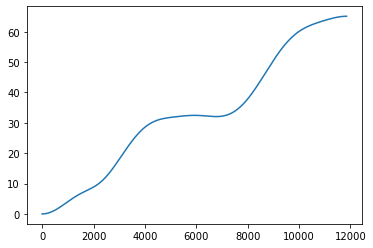

In [12]:
import matplotlib.pyplot as plt
sv0 =  StateVector(*s1a_orbit[0])
dt=[]
err=[]
for ix in range(s1a_orbit.number_state_vectors):
    sv_ref = StateVector(*s1a_orbit[ix])
    dt_ = sv_ref.t - sv0.t
    
    dt.append(dt_)
    #propagate are the  requested time
    orb_ = s1a_orbit_propagator.propagate(dt_*u.s) 
    
    #compute the orbital reference position in ECI 
    sv_ref_eci = sv_ref.to_eci()
    sv_ref_eci = np.asarray([sv_ref_eci.x.value, sv_ref_eci.y.value, sv_ref_eci.z.value] )
    
    # compute the euclidean distance as a measure of the propagation accuracy
    err.append( np.linalg.norm( orb_.r.si.value - sv_ref_eci))
plt.plot(np.asarray(dt), np.asarray(err)/1000)
